# Compare QTLs for tomato fruit shape and potato tuber shape

## Background

Tomato fruits have a round shape while the potato tubers have an elongated shape. The candidate gene _Solyc10g076180_ ( _SlOFP20_ , a member of the OVATE Family Protein [OFP]) on the chromosome 10 of the reference tomato genome (Heinz 1706) is responsible for round fruits. However, this gene does not have an ortholog in the reference potato genome (DM), which results in elongated tuber (<a href="https://dx.doi.org/10.1038%2Fs41467-018-07216-8">Wu et al., 2018</a>). This notebook uses the <a href="http://grlc.io/">grlc</a>-based Web API of the <a href="https://doi.org/10.5281/zenodo.1458168">pbg-ld</a> platform to map QTL regions for the traits in both tomato and potato as well as to retrieve annotations for the genes in the QTLs.

In [1]:
import io
import requests
import ipywidgets
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

try:
    from networkx.drawing.nx_pydot import graphviz_layout
except ImportError:
    raise ImportError("This example needs Graphviz and either PyGraphviz or Pydot")

from ipywidgets import interactive

In [2]:
# display-related options
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width', 0)

In [3]:
# Web API
base_url = None
hosts = {'local': 'http://localhost:8088/api-local/',
         'remote': 'http://example.com/api-git/candYgene/queries'}
headers = {'accept': 'text/csv'} # request content in CSV

In [4]:
# create a widget with a drop-down list of hosts
def setWebAPI(host):
    print(host)
    return host
w = interactive(setWebAPI, host=hosts)

In [5]:
display(w) # default host 'local'

interactive(children=(Dropdown(description='host', options={'local': 'http://localhost:8088/api-local/', 'remo…

In [6]:
base_url = w.result
#print(base_url)

In [7]:
# the fine-mapped locus sov1 (suppressor of ovate) on chr10 includes three genes,
# Solyc10g076170, Solyc10g076180 (SlOFP20) and Solyc10g076190,
# but use only the 'flanking' genes as input
input_data = dict(genes=['Solyc10g076170', 'Solyc10g076190'],
                  taxon_id=4081,
                  graph_iri='http://solgenomics.net/genome/Solanum_lycopersicum')

In [8]:
# retrieve genomic locations for the genes
genes = pd.DataFrame()
feature = 'protein_coding_gene'
try:
    for g in input_data['genes']:
        if g is not None:
            with requests.get(base_url + '/getFeatureLocation',
                              params = {'featureid': "'%s*'" % g}, # append wildcard '*'
                              headers = headers) as req:
                genes = genes.append(pd.read_csv(io.StringIO(req.text)).query('feature_name==@feature'),
                                     ignore_index=True)
except:
    print('Failed fetch data from Web API!')

In [9]:
display(genes)

,feature_id,feature_name,chrom,begin_pos,end_pos,taxon_id
0,Solyc10g076170.1,protein_coding_gene,chromosome 10,58981351,58981887,NCBITaxon:4081
1,Solyc10g076190.1,protein_coding_gene,chromosome 10,59045991,59047132,NCBITaxon:4081


In [10]:
# compute the QTL interval based on the 'flanking' genes' start/end positions
pos = pd.concat([genes['begin_pos'], genes['end_pos']]).describe()

In [11]:
qtl_inter = dict(chrom=genes['chrom'].unique()[0],
                 taxon_id=genes['taxon_id'].unique()[0],
                 begin=int(pos['min']),
                 end=int(pos['max']))

In [12]:
display(qtl_inter)

{'chrom': 'chromosome 10',
 'taxon_id': 'NCBITaxon:4081',
 'begin': 58981351,
 'end': 59047132}

In [13]:
# retrieve genes in the genomic interval
genes_inter = pd.DataFrame()
params = {'feature': feature,
          'chrom': qtl_inter['chrom'],
          'graph': input_data['graph_iri'],
          'begin': qtl_inter['begin'],
          'end': qtl_inter['end']}
try:
    with requests.get(base_url + '/getFeaturesInInterval',
                      params=params,
                      headers=headers) as req:
        genes_inter = pd.read_csv(io.StringIO(req.text))
except:
    print('Failed fetch data from Web API!')

In [14]:
display(genes_inter.sort_values(['chrom', 'begin_pos']))

,feature_id,feature_name,chrom,begin_pos,end_pos
0,Solyc10g076170.1,protein_coding_gene,chromosome 10,58981351,58981887
1,Solyc10g076180.1,protein_coding_gene,chromosome 10,59006329,59007294
2,Solyc10g076190.1,protein_coding_gene,chromosome 10,59045991,59047132


In [15]:
# for each gene retrieve annotations from SGN, Ensembl Plants and UniProt/GOA
genes_annot = pd.DataFrame()
try:
    for g in genes_inter['feature_id']:
        with requests.get(base_url + '/getGeneAnnotations',
                          params={'geneid': "'%s'" % g},
                          headers=headers) as req:
            genes_annot = genes_annot.append(pd.read_csv(io.StringIO(req.text)), ignore_index=True).fillna('')
except:
    print('Failed fetch data from Web API!')

In [16]:
display(genes_annot)

,gene_id,gene_name,transcript_id,sgn_des,uniprot_acc,uniprot_reviewed,uniprot_existence,uniprot_des,uniprot_goa
0,Solyc10g076170.1,,Solyc10g076170.1.1,Name: Solyc10g076170.1.1; Note: Unknown Protein (AHRD V1),,,,,
1,Solyc10g076180.1,,Solyc10g076180.1.1,"Name: Solyc10g076180.1.1; Note: Plant-specific domain TIGR01568 family protein (AHRD V1 *--- B6U561_MAIZE); contains Interpro domain(s) IPR006458 Protein of unknown function DUF623, plant",,,,,
2,Solyc10g076190.1,,Solyc10g076190.1.1,"Name: Solyc10g076190.1.1; Note: Peroxidase 1 (AHRD V1 ***- A0SWU6_SESRO); contains Interpro domain(s) IPR002016 Haem peroxidase, plant/fungal/bacterial ; Ontology_term: GO:0055114; interpro2go_term: GO:0055114",,,,,


In [17]:
# get paralogs of the tomato candidate gene
gene_id = 'Solyc10g076180.1'
edges=dict(para=pd.DataFrame(),
           ortho=pd.DataFrame())
try:
    with requests.get(base_url + '/getParalogs',
                      params={'geneid': "'%s'" % gene_id},
                      headers=headers) as req:
        edges['para'] = pd.read_csv(io.StringIO(req.text))
except:
    print('Failed fetch data from Web API!')

In [18]:
display(edges['para'])

,gene_id,paralog_id
0,Solyc10g076180.1,Solyc01g007800.2
1,Solyc10g076180.1,Solyc02g072030.1
2,Solyc10g076180.1,Solyc02g085500.2
3,Solyc10g076180.1,Solyc03g034100.2
4,Solyc10g076180.1,Solyc04g080210.1
5,Solyc10g076180.1,Solyc06g082460.1
6,Solyc10g076180.1,Solyc08g068170.1
7,Solyc10g076180.1,Solyc09g018200.1
8,Solyc10g076180.1,Solyc10g082050.1
9,Solyc10g076180.1,Solyc11g068780.1


In [19]:
# get potato orthologs of the tomato homologs
try:
    for g in set(edges['para']['paralog_id']) | set([gene_id]):
        with requests.get(base_url + '/getOrthologs',
                          params={'geneid': "'%s'" % g},
                          headers=headers) as req:
            df = pd.read_csv(io.StringIO(req.text))
            if df.size == 0:
                df = {'gene_id': g, 'ortholog_id': None}
            edges['ortho'] = edges['ortho'].append(df, ignore_index=True)
except:
    print('Failed fetch data from Web API!')

In [20]:
display(edges['ortho'])

,gene_id,ortholog_id
0,Solyc08g068170.1,PGSC0003DMG400014511
1,Solyc04g080210.1,PGSC0003DMG400044629
2,Solyc11g068780.1,PGSC0003DMG400019628
3,Solyc03g034100.2,PGSC0003DMG400017788
4,Solyc10g076180.1,None
5,Solyc06g082460.1,PGSC0003DMG400030384
6,Solyc01g007800.2,PGSC0003DMG400016415
7,Solyc02g085500.2,PGSC0003DMG400012688
8,Solyc09g018200.1,PGSC0003DMG400004418
9,Solyc02g072030.1,PGSC0003DMG400028460


In [21]:
# write results into a CSV file
edges['ortho'].set_index('gene_id').to_csv('orthologs.csv')

In [22]:
# count orthologs per gene
display(edges['ortho'].groupby(['gene_id'])['ortholog_id']
        .agg(['count'])
        .sort_values(['count', 'gene_id'], ascending=False)
        .rename(columns={'count':'n_orthologs'})
        .reset_index())

,gene_id,n_orthologs
0,Solyc11g068780.1,1
1,Solyc10g082050.1,1
2,Solyc09g018200.1,1
3,Solyc08g068170.1,1
4,Solyc06g082460.1,1
5,Solyc04g080210.1,1
6,Solyc03g034100.2,1
7,Solyc02g085500.2,1
8,Solyc02g072030.1,1
9,Solyc01g007800.2,1


In [23]:
edges['ortho'] = edges['ortho'].query('ortholog_id.notnull()')

### N.B.: The candidate gene _Solyc10g076180_ does not have an ortholog in potato.

In [24]:
# get additional paralogs of the tomato/potato homologs
try:
    for g in set(edges['para']['paralog_id']) | set(edges['ortho']['ortholog_id']):
        with requests.get(base_url + '/getParalogs',
                          params={'geneid': "'%s'" % g},
                          headers=headers) as req:
            edges['para'] = edges['para'].append(pd.read_csv(io.StringIO(req.text)), ignore_index=True)
except:
    print('Failed fetch data from Web API!')

In [25]:
display(edges['para'])

,gene_id,paralog_id
0,Solyc10g076180.1,Solyc01g007800.2
1,Solyc10g076180.1,Solyc02g072030.1
2,Solyc10g076180.1,Solyc02g085500.2
3,Solyc10g076180.1,Solyc03g034100.2
4,Solyc10g076180.1,Solyc04g080210.1
5,Solyc10g076180.1,Solyc06g082460.1
6,Solyc10g076180.1,Solyc08g068170.1
7,Solyc10g076180.1,Solyc09g018200.1
8,Solyc10g076180.1,Solyc10g082050.1
9,Solyc10g076180.1,Solyc11g068780.1


In [26]:
# write results into a CSV file
edges['para'].sort_values(['gene_id']).set_index('gene_id').to_csv('paralogs.csv')

In [27]:
# count paralogs per gene
display(edges['para'].groupby(['gene_id'])['paralog_id']
        .agg(['count'])
        .sort_values(['count', 'gene_id'], ascending=False)
        .rename(columns={'count':'n_paralogs'})
        .reset_index())

,gene_id,n_paralogs
0,Solyc11g068780.1,10
1,Solyc10g082050.1,10
2,Solyc10g076180.1,10
3,Solyc09g018200.1,10
4,Solyc08g068170.1,10
5,Solyc06g082460.1,10
6,Solyc04g080210.1,10
7,Solyc03g034100.2,10
8,Solyc02g085500.2,10
9,Solyc02g072030.1,10


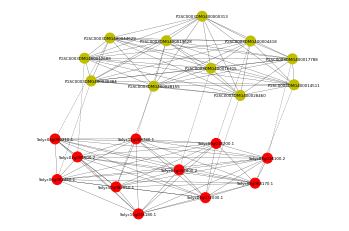

In [28]:
# visualize tomato/potato genes (nodes) and their ortho/paralogous relations (edges) in a graph
G = nx.Graph()
G.add_edges_from(edges['para'].values, style='-')  # add paralogous relations (solid edges)
G.add_edges_from(edges['ortho'].values, style='-.') # add orthologous relations (dotted edges)
style_map = [G[u][v]['style'] for u,v in G.edges()]
color_map = []
for i,n in enumerate(G.nodes()):
    if 'Solyc' in n:
        color_map.append('r') # tomato genes in red
    else:
        color_map.append('y') # potato genes in yellow
pos = graphviz_layout(G, prog='neato')
plt.margins(0.2, 0.05)
nx.draw(G, pos, node_size=100, node_color=color_map, style=style_map, width=0.2, font_size=4, with_labels=True)
plt.savefig('homologs_graph.svg')

In [29]:
# for each gene retrieve annotations from SGN, Ensembl Plants and UniProt/GOA
genes_annot = pd.DataFrame()
genes_loc = pd.DataFrame()
try:
    for g in G.nodes():
        with requests.get(base_url + '/getFeatureLocation',
                          params={'featureid': "'%s'" % g},
                          headers=headers) as req:
            genes_loc = genes_loc.append(pd.read_csv(io.StringIO(req.text)), ignore_index=True)

        with requests.get(base_url + '/getGeneAnnotations',
                          params={'geneid': "'%s'" % g},
                          headers=headers) as req:
            genes_annot = genes_annot.append(pd.read_csv(io.StringIO(req.text)).fillna(''), ignore_index=True)
except:
    print('Failed fetch data from Web API!')

In [30]:
# inner join of both genes* tables
genes_annot = pd.merge(genes_loc.rename(columns={'feature_id': 'gene_id'}).drop(['feature_name'], axis=1),
                       genes_annot, on='gene_id').sort_values(['gene_id', 'chrom', 'begin_pos'])

In [31]:
display(genes_annot.reset_index(drop=True))

,gene_id,chrom,begin_pos,end_pos,taxon_id,gene_name,transcript_id,sgn_des,uniprot_acc,uniprot_reviewed,uniprot_existence,uniprot_des,uniprot_goa
0,PGSC0003DMG400000313,chromosome 12,4510044,4511292,NCBITaxon:4113,102593156,PGSC0003DMT400000838,name: Ovate,M0ZHF0,0,Predicted,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]"
1,PGSC0003DMG400004418,chromosome 9,15532653,15533688,NCBITaxon:4113,,PGSC0003DMT400011286,name: ATOFP3/OFP3,M0ZZB6,0,Predicted,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0003677 [DNA binding]; GO:0005730 [nucleolus]; GO:0005856 [cytoskeleton]; GO:0045892 [negative regulation of transcription, DNA-templated]; GO:0051510 [regulation of unidimensional cell growth]"
2,PGSC0003DMG400004418,chromosome 9,15532653,15533688,NCBITaxon:4113,,PGSC0003DMT400011285,name: ATOFP3/OFP3,M0ZZB5,0,Predicted,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]"
3,PGSC0003DMG400012688,chromosome 2,40752283,40754017,NCBITaxon:4113,,PGSC0003DMT400033048,name: Ovate protein,M1AYJ0,0,Predicted,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]"
4,PGSC0003DMG400014511,chromosome 8,43072980,43074248,NCBITaxon:4113,,PGSC0003DMT400037629,name: ATOFP8/OFP8,M1B5M3,0,Predicted,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]"
5,PGSC0003DMG400016415,chromosome 1,3359907,3360814,NCBITaxon:4113,102586159,PGSC0003DMT400042334,name: Conserved gene of unknown function,M1BCV1,0,Predicted,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]"
6,PGSC0003DMG400017788,chromosome 3,4403368,4405474,NCBITaxon:4113,102580284,PGSC0003DMT400045857,name: Ovate,M1BIB0,0,Predicted,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]"
7,PGSC0003DMG400019628,chromosome 11,40682903,40683552,NCBITaxon:4113,107057995,PGSC0003DMT400050511,name: ATOFP6/OFP6,M1BQE8,0,Predicted,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]"
8,PGSC0003DMG400028155,chromosome 10,56030393,56031156,NCBITaxon:4113,102586649,PGSC0003DMT400072347,name: Conserved gene of unknown function,M1CQ43,0,Predicted,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]"
9,PGSC0003DMG400028460,chromosome 2,31424122,31425454,NCBITaxon:4113,102580543,PGSC0003DMT400073252,name: ATOFP5/OFP5,M1CRN9,0,Predicted,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]"


In [32]:
# write results into a CSV file
genes_annot.set_index('gene_id').to_csv('homologs_annot.csv')